In [1]:
from scipy.ndimage import convolve
import scipy.ndimage
import torchvision

interactive_fig = None
interactive_fig_styles = None

def plot_images(images, titles, figure_size):
    %matplotlib inline
    if interactive_fig is not None:
        plt.close(interactive_fig)
    if interactive_fig_styles is not None:
        plt.close(interactive_fig_styles)
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(len(images)):
        image = images[i]
        title = titles[i]
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        
def plot_masks(masks, titles, figure_size=(15, 5)):
    masks = [mask.squeeze(0).cpu().numpy() for mask in masks] 
    num_masks = len(masks)

    plt.figure(figsize=figure_size)
    for i, mask in enumerate(masks):
        plt.subplot(1, num_masks, i + 1)
        plt.imshow(mask, cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

def resize_to(image, target):
    target_height, target_width = target.shape[:2]
    image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return image

def regenerate(org_image, masked_image, mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        mask = cv2.resize(mask, (org_image.shape[1], org_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = mask.astype(np.uint8)
        
    inverse_mask = cv2.bitwise_not(mask)
    masked_original = cv2.bitwise_and(org_image, org_image, mask=inverse_mask)
    styled_masked = cv2.bitwise_and(masked_image, masked_image, mask=mask)
    return cv2.add(masked_original, styled_masked) 

def plot_tensor_image(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    
    tensor = tensor.detach()
    
    if tensor.dim() == 4 and tensor.size(0) == 1 and tensor.size(1) == 1:
        tensor = tensor.squeeze(0).squeeze(0)  
        plt.imshow(tensor.numpy(), cmap='gray')
    elif tensor.dim() == 3 and tensor.size(0) == 1:
        tensor = tensor.squeeze(0)
        plt.imshow(tensor.numpy(), cmap='gray')
    elif tensor.dim() == 3 and tensor.size(0) in [1, 3]:
        tensor = tensor.permute(1, 2, 0).numpy()
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min()) 
        plt.imshow(tensor)
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    plt.axis('off')  # Hide axis
    plt.show()

def extract_borders(mask, border_thickness, border_type='inner'):
    binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]
    
    kernel = np.ones((border_thickness, border_thickness), np.uint8)
    
    if border_type == 'inner':
        # Erode the mask for inner borders
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        border_mask = binary_mask - eroded_mask
    elif border_type == 'outer':
        # Dilate the mask for outer borders
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        border_mask = dilated_mask - binary_mask
    elif border_type == 'both':
        # Extract both inner and outer borders
        eroded_mask = cv2.erode(binary_mask, kernel, iterations=1)
        inner_border_mask = binary_mask - eroded_mask
        
        dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        outer_border_mask = dilated_mask - binary_mask
        
        # Combine inner and outer borders
        border_mask = cv2.bitwise_or(inner_border_mask, outer_border_mask)
    else:
        raise ValueError("border_type must be either 'inner', 'outer', or 'both'")
    
    return border_mask

def apply_border_mask(image, mask, border_thickness, border_type='inner'):
    border_mask = extract_borders(mask, border_thickness, border_type=border_type)
    border_mask_3channel = cv2.merge([border_mask]*3)
    border_extracted_image = cv2.bitwise_and(image, border_mask_3channel)
    return border_extracted_image
    
def penetrate_mask(mask, radius, shrink=0):
    import scipy.ndimage 
    import numpy as np

    mask = mask.float()
    mask_np = mask.squeeze(0).cpu().numpy() 

    if shrink > 0:
        eroded_mask_np = scipy.ndimage.binary_erosion(mask_np, iterations=shrink).astype(mask_np.dtype)
    else:
        eroded_mask_np = mask_np

    distance_map = scipy.ndimage.distance_transform_edt(eroded_mask_np == 0)
    penetration_mask_np = np.clip((radius - distance_map) / radius, 0, 1)
    penetration_mask = torch.tensor(penetration_mask_np, device=mask.device, dtype=mask.dtype).unsqueeze(0)

    return penetration_mask 

def get_mask_borders(mask, inside_pixels, outside_pixels):
    mask = (mask > 0).astype(np.uint8)
    inside_eroded = cv2.erode(mask, np.ones((inside_pixels, inside_pixels), np.uint8)) if inside_pixels > 0 else mask
    outside_dilated = cv2.dilate(mask, np.ones((outside_pixels, outside_pixels), np.uint8)) if outside_pixels > 0 else mask
    border_mask = outside_dilated - inside_eroded
    return border_mask


In [2]:
import os
import subprocess

from libs import Matrix, models, Matrix_masked, models_masked
from libs.Matrix import MulLayer
from libs.models import encoder4, decoder4
from libs.Matrix_masked import MulLayer as MulLayer_m
from libs.models_masked import encoder4 as encoder_m, decoder4 as decoder_m

import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch.nn as nn
from skimage.feature import local_binary_pattern
from scipy.spatial import distance
from scipy.stats import chisquare
from skimage.color import rgb2lab
from skimage.color import deltaE_ciede2000

def generateSmallMask(x, mask):
    b, c, h, w = x.shape
    small_mask = mask
    small_mask = torch.nn.functional.interpolate(small_mask, size=(h, w), mode='bilinear', align_corners=False)
    return small_mask.squeeze(0)

def gramMatrix(features):
    # Assumes flattened input
    b, c, l = features.size()
    G = torch.bmm(features,features.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
    return G.div_(c*l)

def styleLoss(features,target,mask):
    ib,ic,ih,iw = features.size()
    iF = features.view(ib,ic,-1)
    imask = mask.view(ib,1,-1)
    iF = iF.masked_select(imask.expand_as(iF) > 0)
    iF = iF.view(ib, ic, -1)
    iMean = torch.mean(iF,dim=2)
    iCov = gramMatrix(iF)

    tb,tc,th,tw = target.size()
    tF = target.view(tb,tc,-1)
    tMean = torch.mean(tF,dim=2)
    tCov = gramMatrix(tF)

    loss = torch.nn.MSELoss(reduction="sum")(iMean,tMean) + torch.nn.MSELoss(reduction="sum")(iCov,tCov)
    return loss/tb

def image_to_tensor(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)
    image = tensor.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))
    image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

def calculate_gradient_magnitude_around_border(image, mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    mask = (mask > 0).astype(np.uint8)
    
    grad_magnitudes = []
    for c in range(3): 
        grad_x = cv2.Sobel(image[:, :, c], cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image[:, :, c], cv2.CV_64F, 0, 1, ksize=3)
        grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
        grad_magnitudes.append(grad_magnitude)
    
    # Combine gradient magnitudes across channels
    gradient_magnitude = np.mean(grad_magnitudes, axis=0)
    
    # Apply the mask to isolate the border
    border_gradient_magnitude = gradient_magnitude * mask
    border_pixels = border_gradient_magnitude[mask > 0]

    mean_gradient = np.mean(border_pixels)
    std_gradient = np.std(border_pixels)
    median_gradient = np.median(border_pixels)
    return mean_gradient, std_gradient, median_gradient

def calculate_texture_continuity(blended_image, inner_border_mask, outer_border_mask, radius=1, n_points=8):
    # Ensure masks are binary
    inner_border_mask = (inner_border_mask > 0).astype(np.uint8)
    outer_border_mask = (outer_border_mask > 0).astype(np.uint8)
    
    lbp_histograms_inner = []
    lbp_histograms_outer = []
    
    # Process each color channel
    for c in range(3):  # For each color channel (assuming BGR format)
        channel_image = blended_image[:, :, c]
        lbp_image = local_binary_pattern(channel_image, n_points, radius, method='uniform')
        
        # Extract LBP values within the inner and outer masks
        inner_area = lbp_image[inner_border_mask > 0]
        outer_area = lbp_image[outer_border_mask > 0]
        
        # Calculate histograms for each channel
        bins = np.arange(0, n_points + 3)
        inner_hist, _ = np.histogram(inner_area, bins=bins)
        outer_hist, _ = np.histogram(outer_area, bins=bins)
        
        lbp_histograms_inner.append(inner_hist)
        lbp_histograms_outer.append(outer_hist)
    
    # Combine histograms from all channels
    inner_hist_total = np.concatenate(lbp_histograms_inner)
    outer_hist_total = np.concatenate(lbp_histograms_outer)
    
    # Normalize histograms
    eps = 1e-10
    inner_hist_total = inner_hist_total.astype(np.float32)
    outer_hist_total = outer_hist_total.astype(np.float32)
    inner_hist_total /= (inner_hist_total.sum() + eps)
    outer_hist_total /= (outer_hist_total.sum() + eps)
    
    # Compute Chi-square distance
    chi2_distance = 0.5 * np.sum(((inner_hist_total - outer_hist_total) ** 2) / (inner_hist_total + outer_hist_total + eps))
    
    return chi2_distance

def calculate_color_continuity(image, border_mask):
    # Ensure border_mask is binary
    border_mask = (border_mask > 0).astype(np.uint8)

    # Get coordinates of border pixels
    border_coords = np.column_stack(np.where(border_mask == 1))

    # Convert image to LAB color space for perceptual color difference
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Initialize list to store color differences
    color_differences = []

    # Define 8-connected neighborhood offsets
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),          (0, 1),
               (1, -1),  (1, 0), (1, 1)]

    # Iterate over each border pixel
    for y, x in border_coords:
        pixel_color = image_lab[y, x, :]  # Border pixel color in LAB

        # Find neighboring pixels outside the border mask
        for dy, dx in offsets:
            ny, nx = y + dy, x + dx

            # Check if neighbor is within image bounds
            if 0 <= ny < border_mask.shape[0] and 0 <= nx < border_mask.shape[1]:
                # Check if neighbor is outside the border mask
                if border_mask[ny, nx] == 0:
                    neighbor_color = image_lab[ny, nx, :]

                    # Compute color difference (CIEDE2000)
                    deltaE = deltaE_ciede2000(pixel_color[np.newaxis, :], neighbor_color[np.newaxis, :])[0]

                    color_differences.append(deltaE)
                    break  # Only consider the first neighbor across the border

    # Convert list to NumPy array
    color_differences = np.array(color_differences)

    # Handle case with no color differences
    if len(color_differences) == 0:
        mean_color_difference = 0
        std_color_difference = 0
        median_color_difference = 0
    else:
        # Compute statistics
        mean_color_difference = np.mean(color_differences)
        std_color_difference = np.std(color_differences)
        median_color_difference = np.median(color_differences)

    return mean_color_difference, std_color_difference, median_color_difference

enc_ref = encoder4()
dec_ref = decoder4()
matrix_ref = MulLayer('r41')

enc_ref.load_state_dict(torch.load('./models/vgg_r41.pth'))
dec_ref.load_state_dict(torch.load('./models/dec_r41.pth'))
matrix_ref.load_state_dict(torch.load('./models/r41.pth', map_location=torch.device('cpu')))

enc_ref_m = encoder_m()
enc_ref_m_wo = encoder_m()
dec_ref_m = decoder_m()
matrix_ref_m = MulLayer_m('r41')

enc_ref_m.load_state_dict(torch.load('models/vgg_r41.pth'))
enc_ref_m_wo.load_state_dict(torch.load('models/vgg_r41.pth'))
dec_ref_m.load_state_dict(torch.load('models/dec_r41.pth'), strict=False)
matrix_ref_m.load_state_dict(torch.load('models/r41.pth', map_location=torch.device('cpu')))

def partial_convolution(content_im, mask, style_image_file, original_feature_sum=False, feathering=False, penetrate_initial_mask_pixels=0, cookie_cutter=False, index=0):
    def visualize_masks(mask_tensors, titles=None, figsize=(12, 6)):
        num_masks = len(mask_tensors)
        titles = titles or [f'Mask {i+1}' for i in range(num_masks)]

        plt.figure(figsize=figsize)

        for i, mask_tensor in enumerate(mask_tensors):
            mask_np = mask_tensor.cpu().numpy()
            mask_np = mask_np.squeeze() 

            plt.subplot(1, num_masks, i + 1)
            plt.imshow(mask_np, cmap='gray')
            plt.title(titles[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    def visualize_feature_maps(feature_maps, titles, rows=2, cols=5):
        plt.figure(figsize=(15, 6))
        for i, feature_map in enumerate(feature_maps):
            plt.subplot(rows, cols, i + 1)
            feature_map_np = feature_map[0, 222].cpu().detach().numpy()
            plt.imshow(feature_map_np, cmap='viridis')
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def resize_style_image_to_mask(mask, style_im):
        if len(mask.shape) == 3 and mask.shape[2] == 3:
            gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
        else:
            gray_mask = mask 

        _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

        non_zero_pixels = cv2.findNonZero(binary_mask)  # Find all non-zero pixel coordinates
        x, y, w, h = cv2.boundingRect(non_zero_pixels)  # Compute bounding box (x, y, width, height)
        style_h, style_w = style_im.shape[:2]
        scale_factor = min(h / style_h, w / style_w)
        new_style_h = int(style_h * scale_factor)
        new_style_w = int(style_w * scale_factor)
        resized_style_im = cv2.resize(style_im, (new_style_w, new_style_h), interpolation=cv2.INTER_AREA)
        return resized_style_im
    
    def blend_styled_edges(original_image, styled_image, mask, alpha=0.5):
        if isinstance(mask, torch.Tensor):
            mask = mask.squeeze().cpu().numpy()

        if mask.shape[:2] != original_image.shape[:2]:
            mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        if len(mask.shape) == 3 and mask.shape[2] == 1:
            mask = mask.squeeze(axis=2)
        elif len(mask.shape) == 3 and mask.shape[2] != 1:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        elif len(mask.shape) != 2:
            raise ValueError("Mask must be 2D or 3D with one channel.")

        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
        else:
            mask = mask.astype(np.uint8)

        original_image = original_image.astype(np.uint8)
        styled_image = styled_image.astype(np.uint8)
            
        inverse_mask = cv2.bitwise_not(mask)

        inverse_masked_original = cv2.bitwise_and(original_image, original_image, mask=inverse_mask)
        inverse_masked_original_bordered = apply_border_mask(inverse_masked_original, inverse_mask, 5, border_type='inner')

        masked_styled = cv2.bitwise_and(styled_image, styled_image, mask=mask)
        inverse_masked_styled = cv2.bitwise_and(styled_image, styled_image, mask=inverse_mask)
        masked_styled_outer = apply_border_mask(inverse_masked_styled, mask, 5, border_type='outer')

        blended_image = cv2.addWeighted(masked_styled_outer, alpha, inverse_masked_original_bordered, 1 - alpha, 0)
        blended_image += inverse_masked_original - inverse_masked_original_bordered
        blended_image += masked_styled

        return blended_image

    masked_im = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    style_im = cv2.imread(style_image_file)
    style_im = resize_style_image_to_mask(mask, style_im)
    
    with torch.no_grad():
        content_tensor = image_to_tensor(content_im)
        style_tensor = image_to_tensor(style_im)

        mask_tensor = image_to_tensor(masked_im)
        mask_tensor = mask_tensor[:, 0:1, :, :]
        
        if penetrate_initial_mask_pixels > 0:
            cF_ref, small_mask = enc_ref_m(content_tensor, penetrate_mask(mask_tensor, penetrate_initial_mask_pixels), cookie_cutter=cookie_cutter)
        else:
            cF_ref, small_mask = enc_ref_m(content_tensor, mask_tensor, cookie_cutter=cookie_cutter)
                
        if original_feature_sum:
            cF_ref_orig, _ = enc_ref_m_wo(content_tensor, cookie_cutter=cookie_cutter)
        else:
            cF_ref_orig = None
        sF_ref, _ = enc_ref_m(style_tensor)
        
        feature_ref, _ = matrix_ref_m(cF_ref['r41'], sF_ref['r41'], small_mask)
        
        result, mask_conv11, mask_conv12, mask_conv13, mask_conv14, mask_conv15, \
        mask_conv16, mask_conv17, mask_conv18, mask_conv19, out11, out12, out13, \
        out14, out15, out16, out17, out18, out19 = dec_ref_m(
            feature_ref, 
            small_mask, 
            original_features=cF_ref_orig, 
            feathering=feathering, 
            cookie_cutter=cookie_cutter
        )
        
        plot_masks([mask_conv11], \
                   ['mask_conv1_1'])
        plot_masks([mask_conv12, mask_conv13, mask_conv14, mask_conv15], \
                   ['mask_conv2_1', 'mask_conv2_2', 'mask_conv2_3', 'mask_conv2_4'])
        plot_masks([mask_conv16, mask_conv17], \
                   ['mask_conv3_1', 'mask_conv3_2'])
        plot_masks([mask_conv18, mask_conv19], \
                   ['mask_conv4_1', 'mask_conv4_2'])                    
        
    processed_image_rgb = tensor_to_image(result)
    processed_image_rgb = resize_to(processed_image_rgb, content_im)
    if feathering:
        processed_image_rgb = blend_styled_edges(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask, alpha=0.5)
    else:
        processed_image_rgb = regenerate(cv2.cvtColor(content_im, cv2.COLOR_BGR2RGB), processed_image_rgb, mask)
    
    ### GRADIENT MAGNITUDE
    mean, std, median = calculate_gradient_magnitude_around_border(processed_image_rgb, get_mask_borders(mask, 2, 5))
    
    ### TEXTURE CONTINUITY
    mask_borders_inner = get_mask_borders(mask, 5, 0)
    mask_borders       = get_mask_borders(mask, 0, 5)
    mask_borders_outer = get_mask_borders(mask, 5, 7)
    texture_continuity_1 = calculate_texture_continuity(processed_image_rgb, mask_borders_inner, mask_borders)
    texture_continuity_2 = calculate_texture_continuity(processed_image_rgb, mask_borders, mask_borders_outer)
    sum_text_continuity = texture_continuity_1 + texture_continuity_2
    
    ### COLOR CONTINUITY
    mean_cc, std_cc, median_cc = calculate_color_continuity(processed_image_rgb, get_mask_borders(mask, 2, 5))
    sum_color_continuity = round(mean_cc, 2) + round(std_cc, 2)
    
    print(f'{i} - {round(mean, 2)} - {round(std, 2)} - {round(texture_continuity_1, 4)} - {round(texture_continuity_2, 4)} - {round(sum_text_continuity, 4)} - {round(mean_cc, 2)} - {round(std_cc, 2)} - {sum_color_continuity}')
    
    total_style_loss = 0.0  
    style_layers = ['r11','r21','r31','r41']
    image_tensor = image_to_tensor(processed_image_rgb)  
    tF, _ = enc_ref_m(image_tensor, mask_tensor) 
    
    for layer in style_layers:
        sf_i = sF_ref[layer]
        sf_i = sf_i.detach() 
        tf_i = tF[layer]
        small_mask = generateSmallMask(tf_i, mask_tensor)
        total_style_loss += styleLoss(tf_i, sf_i, small_mask)
    
    #print("Total Style Loss:", total_style_loss.item())
    
    return processed_image_rgb, round(mean, 2), round(std, 2), round(median, 2), round(total_style_loss.item(), 2) , sum_text_continuity, sum_color_continuity
    

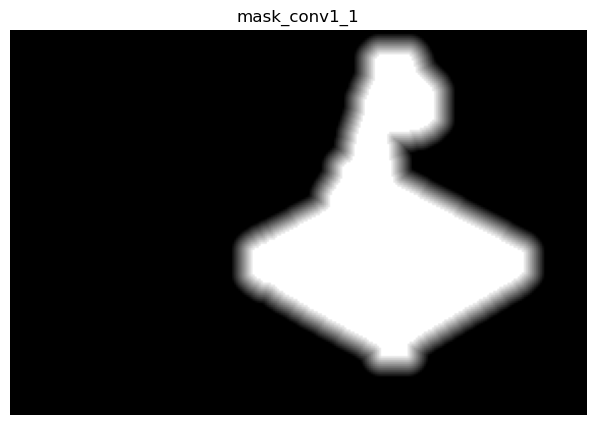

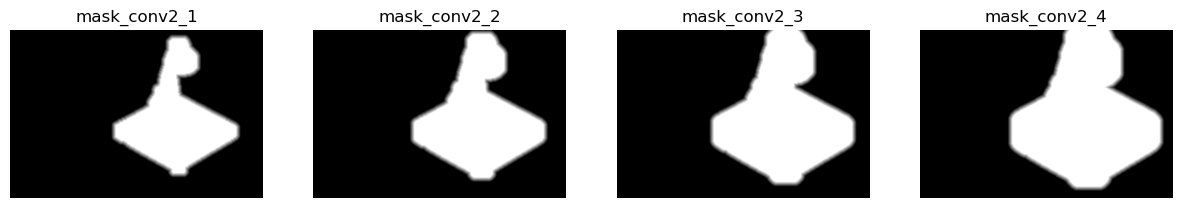

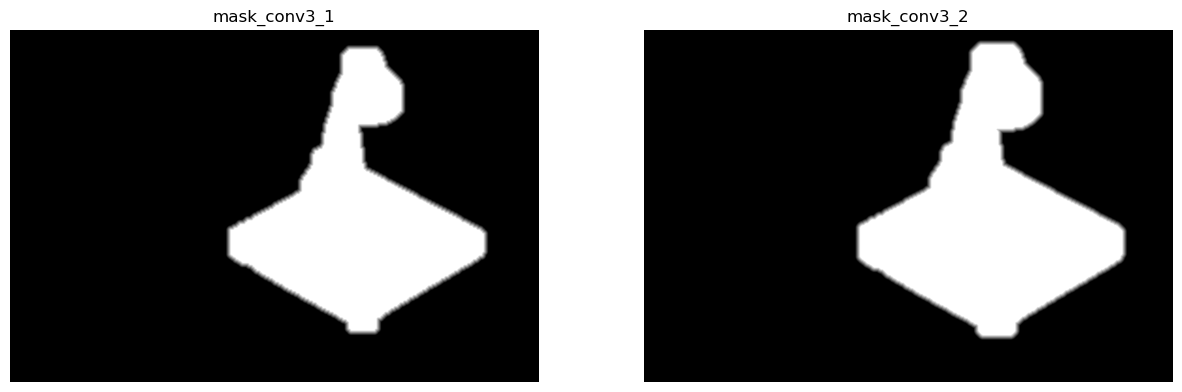

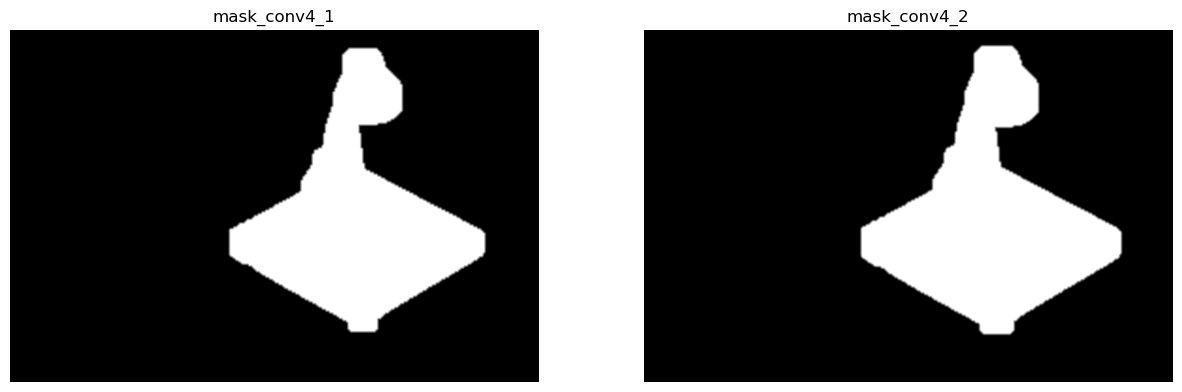

1 - 164.61 - 105.16 - 0.0517 - 0.0104 - 0.0621 - 14.4 - 12.05 - 26.450000000000003
Processing complete. Report saved to ./results/gradient_style_report.csv


In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools import mask as mask_utils
import random

# Directory path
data_dir = '/Users/ayberk.cansever/Documents/ECU/Thesis/SAM/dataset'

def decode_rle(rle, shape):
    binary_mask = mask_utils.decode(rle)
    return binary_mask

def extract_large_mask(data, shape, min_area):
    largest_mask = None
    largest_area = 0
    stability_score = 0
    
    for annotation in data.get("annotations", []):
        rle = annotation.get("segmentation")
        stability_score = annotation.get("stability_score")
        if rle:
            binary_mask = decode_rle(rle, shape)
            mask_area = np.sum(binary_mask)
            
            # Return the binary mask as an OpenCV-compatible image if it meets the min_area requirement
            if mask_area >= min_area:
                return (binary_mask * 255).astype(np.uint8), stability_score  # Convert to OpenCV-compatible format
            
            # Track the largest mask if no mask meets the min_area requirement
            if mask_area > largest_area:
                largest_area = mask_area
                largest_mask = binary_mask            
                
    # If no mask meets min_area, return the largest one in OpenCV format
    if largest_mask is not None:
        return (largest_mask * 255).astype(np.uint8), stability_score
    else:
        return None, None  # Return None if no masks are available

#style_image_files = [cv2.cvtColor(cv2.imread(f'./styles/style-{i}.jpg'), cv2.COLOR_BGR2RGB) for i in range(8)]
#style_image_files = [f'./results/styles/style-{i}.jpg' for i in range(6)]
style_image_files = [f'./styles/paper-style-{i}.jpg' for i in range(2)]

feature_combinations = [
    #{"cookie_cutter": True,  "penetrate_initial_mask_pixels": 0, "feathering": False},   #1 o,x,x
    #{"cookie_cutter": False, "penetrate_initial_mask_pixels": 9, "feathering": False},   #2 x,o,x
    #{"cookie_cutter": False, "penetrate_initial_mask_pixels": 0, "feathering": True},    #3 x,x,o
    #{"cookie_cutter": True,  "penetrate_initial_mask_pixels": 9, "feathering": False},   #4 o,o,x
    #{"cookie_cutter": True,  "penetrate_initial_mask_pixels": 0, "feathering": True},    #5 o,x,o
    #{"cookie_cutter": False, "penetrate_initial_mask_pixels": 9, "feathering": True},    #6 x,o,o
    {"cookie_cutter": True,  "penetrate_initial_mask_pixels": 9, "feathering": True},    #7 o,o,o
    #{"cookie_cutter": False, "penetrate_initial_mask_pixels": 0, "feathering": False}    #8 x,x,x
]

# Initialize output file
output_file = "./results/gradient_style_report.csv"
with open(output_file, "w") as report_file:
    report_file.write("Feature_Combination,Filename,Style,Stability_Score,Mean_Gradient,Std_Gradient,Text_Continuity,Color_Continuity,Total_Style_Loss\n")

# Loop through images
for img_index in range(1, 8):
    file = f"sa_{img_index}.jpg"
    filename = file.replace('.jpg', '')
    img_path = os.path.join(data_dir, file)
    json_path = img_path.replace('.jpg', '.json')
    
    # Load the image and mask
    image_to_be_processed = cv2.imread(img_path)
    if image_to_be_processed is None:
        print(f"Image {file} not found. Skipping.")
        continue
    with open(json_path, 'r') as json_file:
        data = json.load(json_file)
        width = data["image"]["width"]
        height = data["image"]["height"]
        image_area = width * height
        min_area = image_area * 0.1
        mask, stability_score = extract_large_mask(data, (height, width), min_area)
        
        if mask is None:
            print(f"No mask found for {file}. Skipping.")
            continue
            
        style_image_filename = random.choice(style_image_files)
        style_image_filename = './results/styles/style-10.jpg'
        style_image = cv2.cvtColor(cv2.imread(style_image_filename), cv2.COLOR_BGR2RGB)
        
        # Apply each feature combination
        for i, features in enumerate(feature_combinations, 1):
            #print(f"{filename} - Feature combination {i} process started...")
            
            # Process the image with partial_convolution
            processed_image, mean, std, median, total_style_loss, sum_text_continuity, sum_color_continuity = partial_convolution(
                image_to_be_processed, 
                mask, 
                style_image_filename, 
                feathering=features["feathering"], 
                penetrate_initial_mask_pixels=features["penetrate_initial_mask_pixels"],
                cookie_cutter=features["cookie_cutter"],
                index=i
            )
            
            # Save the processed image
            cv2.imwrite(f'./results/{filename}_feature_{i}.jpg', cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
            
            # Log the results
            with open(output_file, "a") as report_file:
                report_file.write(f"{i},{filename},{style_image_filename},{stability_score},{mean},{std},{sum_text_continuity},{sum_color_continuity},{total_style_loss}\n")
            
            #print(f"{filename} - Feature combination {i} process completed and saved.")

print("Processing complete. Report saved to", output_file)


In [2]:
import pandas as pd

file_path = "./results/11-24-2024/gradient_style_report.csv"
df = pd.read_csv(file_path)

average_std_gradient = round(df.groupby('Feature_Combination')['Std_Gradient'].mean(), 2)
print(average_std_gradient)

average_text_continuity = round(df.groupby('Feature_Combination')['Text_Continuity'].mean(), 4)
print(average_text_continuity)

average_color_continuity = round(df.groupby('Feature_Combination')['Color_Continuity'].mean(), 4)
print(average_color_continuity)


Feature_Combination
1    142.89
2    135.31
3     90.38
4    129.93
5     88.03
6     84.61
7     82.65
8    157.05
Name: Std_Gradient, dtype: float64
Feature_Combination
1    0.1227
2    0.1377
3    0.0829
4    0.1305
5    0.0869
6    0.1025
7    0.0923
8    0.1322
Name: Text_Continuity, dtype: float64
Feature_Combination
1    28.8362
2    28.0212
3    33.4971
4    27.0127
5    30.9312
6    27.9826
7    26.2305
8    31.1920
Name: Color_Continuity, dtype: float64
